In [2]:
import numpy as np

### Creating your own GRN

In [13]:
num_genes = 15
cell_types = 3
master_regulators = 3


# Generate the cell lineage first

In [61]:
import random
import time

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def get_adjacency_matrix(G):
    """Convert the NetworkX graph G into a numpy adjacency matrix."""
    return nx.to_numpy_array(G, dtype=int)

def generate_random_cell_cycle(total_nodes=None,
                               min_per_rank=2,
                               max_per_rank=3,
                               min_ranks=1,
                               max_ranks=5,
                               percent=0):
    """
    Generate a DAG:
      - If total_nodes is specified, create exactly that many nodes.
      - Otherwise, layer by ranks between min_ranks and max_ranks,
        each rank having between min_per_rank and max_per_rank nodes.
      - Optionally add extra random edges with probability 'percent'%.
    """
    random.seed(time.time())
    G = nx.DiGraph()

    if total_nodes is not None:
        G.add_nodes_from(range(total_nodes))
        for i in range(1, total_nodes):
            src = random.randint(0, i-1)
            G.add_edge(src, i)
            for j in range(i):
                if random.randint(0, 99) < percent:
                    G.add_edge(j, i)
        return G

    nodes = 0
    ranks = random.randint(min_ranks, max_ranks)
    all_ranks = []
    for _ in range(ranks):
        new_nodes = random.randint(min_per_rank, max_per_rank)
        current_rank = list(range(nodes, nodes + new_nodes))
        G.add_nodes_from(current_rank)

        if all_ranks:
            prev = all_ranks[-1]
            for n in current_rank:
                G.add_edge(random.choice(prev), n)
        else:
            # chain the first rank if multiple
            for i in range(len(current_rank)-1):
                G.add_edge(current_rank[i], current_rank[i+1])

        # extra random edges
        for j in range(nodes):
            for n in current_rank:
                if random.randint(0, 99) < percent:
                    G.add_edge(j, n)

        nodes += new_nodes
        all_ranks.append(current_rank)

    return G

def visualize_dag(G, interactions=None):
    """
    Display the DAG with spring layout (k=0.9).
    If interactions is provided, color edges red for inhibitory, green for upregulating.
    """
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)

    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    nx.draw_networkx_labels(G, pos, font_size=10)

    if interactions is None:
        nx.draw_networkx_edges(
            G, pos,
            edge_color='gray',
            arrows=True,
            arrowstyle='-|>',
            arrowsize=20,
            width=1.5
        )
    else:
        edge_list   = [(a, t) for (t, _, a, _, _) in interactions]
        edge_colors = ['red' if mag < 0 else 'green'
                       for (_, _, _, mag, _) in interactions]
        nx.draw_networkx_edges(
            G, pos,
            edgelist=edge_list,
            edge_color=edge_colors,
            arrows=True,
            arrowstyle='-|>',
            arrowsize=20,
            width=2
        )

    plt.title("Randomly Generated DAG")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
    """Replace each 1 in the matrix with a random float between min_val and max_val."""
    perturbed = matrix.astype(float).copy()
    ones = np.where(matrix == 1)
    for i, j in zip(*ones):
        perturbed[i][j] = round(random.uniform(min_val, max_val), 1)
    return perturbed

def find_isolated_nodes(G):
    """Return nodes that have no incoming and no outgoing edges."""
    return [n for n in G.nodes()
            if G.in_degree(n) == 0 and G.out_degree(n) == 0]

def generate_interactions_from_dag(G,
                                   scalar=2.0,
                                   mag_range=(0.5, 5.0),
                                   inhibit_pct=50):
    """
    Convert DAG edges into (target, type, affector, magnitude, scalar).
    inhibit_pct: percent chance an edge is inhibitory (negative).
    """
    interactions = []
    for u, v in G.edges():
        mag = round(random.uniform(*mag_range), 2)
        if random.randint(1, 100) <= inhibit_pct:
            mag = -abs(mag)
        else:
            mag = abs(mag)
        interactions.append((v, 1, u, mag, scalar))
    return interactions

def main(mode,
         total_nodes=None,
         min_per_rank=2,
         max_per_rank=3,
         min_ranks=1,
         max_ranks=5,
         percent=0,
         inhibit_pct=50):
    """
    mode: 'cell' → output adjacency + perturbed matrices
          'gene' → output gene interactions
    Other params adjust graph structure & inhibition chance.
    """
    dag = generate_random_cell_cycle(
        total_nodes,
        min_per_rank,
        max_per_rank,
        min_ranks,
        max_ranks,
        percent
    )
    # Pre-generate interactions for coloring in gene mode
    interactions = generate_interactions_from_dag(dag, inhibit_pct=inhibit_pct)

    # Visualize
    visualize_dag(dag, interactions if mode == 'gene' else None)

    # Always print isolated nodes
    iso = find_isolated_nodes(dag)
    print("Isolated Nodes:", iso)

    if mode == 'cell':
        matrix = get_adjacency_matrix(dag)
        print("\nAdjacency Matrix:\n", matrix)

        perturbed = perturb_adjacency_matrix(matrix)
        print("\nPerturbed Adjacency Matrix:\n", perturbed)

        with open("perturbed_matrix.tab", "w") as f:
            for row in perturbed:
                f.write("\t".join(map(str, row)) + "\n")
        print("\nPerturbed matrix written to perturbed_matrix.tab")

    elif mode == 'gene':
        print("\nGenerated Gene Regulatory Interactions:")
        print("(target, type, affector, magnitude, scalar)")
        for inter in interactions:
            print(inter)
    else:
        raise ValueError("Mode must be 'cell' or 'gene'")

# Example direct calls:
# main('cell', total_nodes=5, min_per_rank=2, max_per_rank=4, min_ranks=1, max_ranks=3, percent=10)
# main('gene', total_nodes=7, inhibit_pct=80)


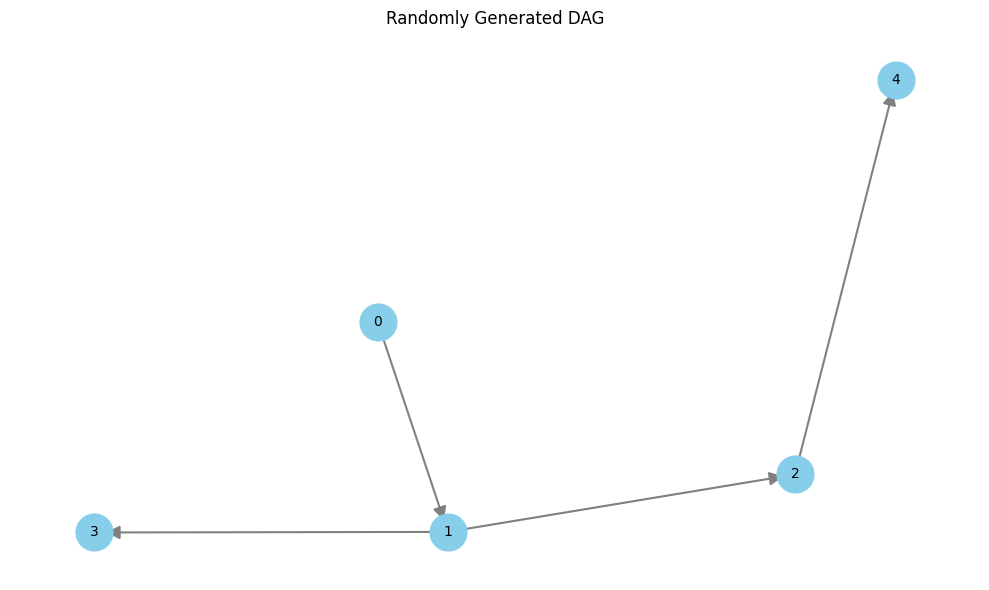

Isolated Nodes: []

Adjacency Matrix:
 [[0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]

Perturbed Adjacency Matrix:
 [[0.  0.9 0.  0.  0. ]
 [0.  0.  0.9 1.  0. ]
 [0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]

Perturbed matrix written to perturbed_matrix.tab


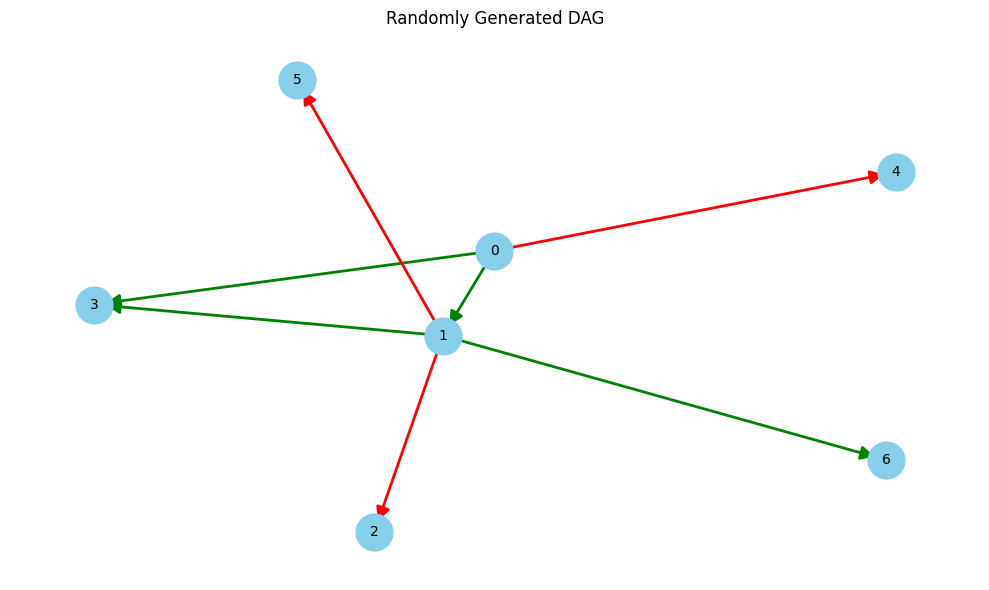

Isolated Nodes: []

Generated Gene Regulatory Interactions:
(target, type, affector, magnitude, scalar)
(1, 1, 0, 4.01, 2.0)
(3, 1, 0, 0.75, 2.0)
(4, 1, 0, -2.87, 2.0)
(2, 1, 1, -4.69, 2.0)
(3, 1, 1, 4.79, 2.0)
(5, 1, 1, -1.99, 2.0)
(6, 1, 1, 1.44, 2.0)


In [62]:
# import this module, then:
main('cell', total_nodes=5, min_per_rank=2, max_per_rank=4, min_ranks=1, max_ranks=3, percent=10)
main('gene', total_nodes=7, min_per_rank=2, max_per_rank=3, min_ranks=1, max_ranks=2, percent=5, inhibit_pct=80)
